# CONCLUSION

  
사용된 Hyper Parameter  
Epoch : 40  
Batch Size : 32  
learning Rate : 0.001  
Loss Function : MultiLabelSoftMarginLoss(with Softmax Layer)  
Optimizer : Adam  
random seed : 77  
Model : CNN  

# IMPORT

In [1622]:
# from google.colab import drive
# drive.mount('/content/drive')

In [1623]:
# cd drive/My Drive/22-2/mid_term_1

In [1624]:
# !pip install pytorch_model_summary

In [1625]:
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader, Dataset
import torch.nn.functional as F
import pytorch_model_summary

import numpy as np
import pickle
import collections

import matplotlib.pyplot as plt

In [1626]:
if torch.cuda.is_available():
    temp_device = 'cuda' 
    torch.cuda.manual_seed_all(77)

# elif torch.backends.mps.is_available():
#     temp_device = 'mps'
## M1 GPU has Error

else:
    temp_device = 'cpu'

device = torch.device(temp_device)
torch.manual_seed(77)

print(device)    

cuda


# PARAMETER

In [1627]:
epoch = 40
batch_size = 32
lr_mag = 0.001
lr_all = 0.001

# DATASET

In [1628]:
with open("label_names.pickle","rb") as fr:
    label_dataset = pickle.load(fr)
    
train_load = np.load('train.npy')
train_label_load = np.load('train_label.npy')
test_load = np.load('test.npy')
test_label_load = np.load('test_label.npy')

In [1629]:
print(label_dataset)
print(f"train_shape : {train_load.shape}")
print(f"train_label_shape : {train_label_load.shape}")
print(f"test_shape : {test_load.shape}")
print(f"test_label_shape : {test_label_load.shape}")

['bmp2_tank', 'btr70_transport', '2s1_gun', 'zsu23-4_gun', 'zil131_truck', 'd7_bulldozer', 't72_tank', 't62_tank', 'brdm2_truck', 'btr60_transport']
train_shape : (3671, 4, 88, 88)
train_label_shape : (3671,)
test_shape : (3203, 4, 88, 88)
test_label_shape : (3203,)


## DATASET INFO

In [1630]:
aUnique = np.array(train_label_load)
bUnique = np.array(test_label_load)

aUnique, acounts = np.unique(aUnique, return_counts=True)
bUnique, bcounts = np.unique(bUnique, return_counts=True)

train_dict = dict(zip(label_dataset, acounts))
test_dict = dict(zip(label_dataset, bcounts))

total_train = sum(train_dict.values())
total_test = sum(test_dict.values())

print("Train : ", train_dict)
print("Test : ", test_dict)

Train :  {'bmp2_tank': 698, 'btr70_transport': 233, '2s1_gun': 299, 'zsu23-4_gun': 299, 'zil131_truck': 299, 'd7_bulldozer': 299, 't72_tank': 691, 't62_tank': 299, 'brdm2_truck': 298, 'btr60_transport': 256}
Test :  {'bmp2_tank': 587, 'btr70_transport': 196, '2s1_gun': 274, 'zsu23-4_gun': 274, 'zil131_truck': 274, 'd7_bulldozer': 274, 't72_tank': 582, 't62_tank': 273, 'brdm2_truck': 274, 'btr60_transport': 195}


<BarContainer object of 10 artists>

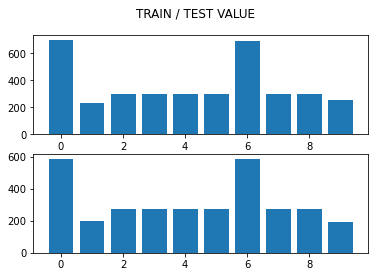

In [1631]:
fig, axs = plt.subplots(2)
fig.suptitle('TRAIN / TEST VALUE')
axs[0].bar(range(len(train_dict)), list(train_dict.values()))
axs[1].bar(range(len(test_dict)), list(test_dict.values()))

# DATASET PREPROCESSING

In [1632]:
train_mag_data = train_load[:,0,:,:]
train_real_data = train_load[:,1,:,:]
train_imag_data = train_load[:,2,:,:]

train_mag_only = np.expand_dims(train_mag_data, axis = 1)

train_all_temp = np.concatenate(
    (np.expand_dims(train_mag_data, axis = 1),
    np.expand_dims(train_real_data, axis = 1),
    np.expand_dims(train_imag_data, axis = 1)),
    axis = 1)

print("train magnitude : ", train_mag_only.shape)
print("train all : ", train_all_temp.shape)

train magnitude :  (3671, 1, 88, 88)
train all :  (3671, 3, 88, 88)


In [1633]:
test_mag_data = test_load[:,0,:,:]
test_real_data = test_load[:,1,:,:]
test_imag_data = test_load[:,2,:,:]

test_mag_only = np.expand_dims(test_mag_data, axis = 1)

test_all_temp = np.concatenate(
    (np.expand_dims(test_mag_data, axis = 1),
    np.expand_dims(test_real_data, axis = 1),
    np.expand_dims(test_imag_data, axis = 1)),
    axis = 1)

print("test magnitude : ", test_mag_only.shape)
print("test all : ", test_all_temp.shape)

test magnitude :  (3203, 1, 88, 88)
test all :  (3203, 3, 88, 88)


In [1634]:
class CustomDataset(Dataset): 
  def __init__(self,x,y):
    self.x_data = x
    self.y_data = y

  def __len__(self):
    return len(self.x_data)

  def __getitem__(self, idx): 
    x = self.x_data[idx].to(device)
    y = self.y_data[idx].to(device)
    return x, y

In [1635]:
train_dataset_mag = CustomDataset(torch.FloatTensor(train_mag_only), torch.LongTensor(train_label_load))
train_dataset_all = CustomDataset(torch.FloatTensor(train_all_temp), torch.LongTensor(train_label_load))

In [1636]:
test_dataset_mag = CustomDataset(torch.FloatTensor(test_mag_only), torch.LongTensor(test_label_load))
test_dataset_all = CustomDataset(torch.FloatTensor(test_all_temp), torch.LongTensor(test_label_load))

In [1637]:
# 메모리 누수 방지용 코드
del train_mag_data
del train_real_data
del train_imag_data
del train_load
del train_label_load
del train_mag_only
del train_all_temp

del test_mag_data
del test_real_data
del test_imag_data
del test_load
del test_label_load
del test_mag_only
del test_all_temp

In [1638]:
train_mag = DataLoader(dataset=train_dataset_mag,
                       batch_size=batch_size,
                       shuffle=True,
                       drop_last = True)
                                          
train_all = DataLoader(dataset=train_dataset_all,
                       batch_size=batch_size,
                       shuffle=True,
                       drop_last = True)

In [1639]:
test_mag = DataLoader(dataset=test_dataset_mag,
                      batch_size=batch_size,
                      shuffle=True,
                      drop_last = True)
                                          
test_all = DataLoader(dataset=test_dataset_all,
                      batch_size=batch_size,
                      shuffle=True,
                      drop_last = True)

# CNN

In [1640]:
class CNN(torch.nn.Module):

    def __init__(self, ch):
        super(CNN, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(ch, 32, 3),
            nn.ReLU()
        )
        self.layer2 = nn.Sequential(
            nn.Conv2d(32, 32, 3),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Dropout(0.25)
        )
        self.layer3 = nn.Sequential(
            nn.Linear(42 * 42 * 32, 128),
            nn.ReLU(),
            nn.Dropout(0.25)
        )
        self.layer4 = nn.Sequential(
            nn.Linear(128, 10),
            nn.Softmax(dim=1)
        )

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = torch.flatten(out,start_dim=1)
        out = self.layer3(out)
        out = self.layer4(out)
        return out

In [1641]:
model_mag = CNN(1).to(device)
model_all = CNN(3).to(device)

In [1642]:
exm_mag = torch.zeros(32,1,88,88).to(device)
exm_all = torch.zeros(32,3,88,88).to(device)

In [1643]:
print(pytorch_model_summary.summary(model_all, exm_all))

------------------------------------------------------------------------
      Layer (type)         Output Shape         Param #     Tr. Param #
          Conv2d-1     [32, 32, 86, 86]             896             896
            ReLU-2     [32, 32, 86, 86]               0               0
          Conv2d-3     [32, 32, 84, 84]           9,248           9,248
            ReLU-4     [32, 32, 84, 84]               0               0
       MaxPool2d-5     [32, 32, 42, 42]               0               0
         Dropout-6     [32, 32, 42, 42]               0               0
          Linear-7            [32, 128]       7,225,472       7,225,472
            ReLU-8            [32, 128]               0               0
         Dropout-9            [32, 128]               0               0
         Linear-10             [32, 10]           1,290           1,290
        Softmax-11             [32, 10]               0               0
Total params: 7,236,906
Trainable params: 7,236,906
Non-trainab

In [1644]:
loss_fn = nn.MultiLabelSoftMarginLoss() 
# loss_fn = nn.CrossEntropyLoss() 

optimizer_mag = torch.optim.Adam(model_mag.parameters(),lr = lr_mag)
optimizer_all = torch.optim.Adam(model_all.parameters(),lr = lr_all)

In [1645]:
all_loss = []
mag_loss = []
all_acc = []
mag_acc = []

In [1646]:
model_mag.train()

for i in range(epoch):
  for batch_idx, samples in enumerate(train_mag):
    x_train, y_train = samples

    prediction = model_mag(x_train)
    # print(prediction.shape)
    # y_train = y_train.squeeze()
    y_train = F.one_hot(y_train,num_classes = 10)
    # print(y_train.shape)
    # y_train = y_train.squeeze()
    cost = loss_fn(prediction, y_train)
    
    optimizer_mag.zero_grad()
    cost.backward()
    optimizer_mag.step()
    
    mag_loss.append(cost)
  print('Epoch {:4d}/{} Cost: {:.6f}'.format(
          i+1, epoch , cost.item()))

Epoch    1/40 Cost: 0.709468
Epoch    2/40 Cost: 0.698724
Epoch    3/40 Cost: 0.681711
Epoch    4/40 Cost: 0.695289
Epoch    5/40 Cost: 0.671398
Epoch    6/40 Cost: 0.664658
Epoch    7/40 Cost: 0.683705
Epoch    8/40 Cost: 0.680455
Epoch    9/40 Cost: 0.667759
Epoch   10/40 Cost: 0.665286
Epoch   11/40 Cost: 0.670786
Epoch   12/40 Cost: 0.667803
Epoch   13/40 Cost: 0.664807
Epoch   14/40 Cost: 0.668360
Epoch   15/40 Cost: 0.677149
Epoch   16/40 Cost: 0.667995
Epoch   17/40 Cost: 0.670621
Epoch   18/40 Cost: 0.674015
Epoch   19/40 Cost: 0.664188
Epoch   20/40 Cost: 0.666562
Epoch   21/40 Cost: 0.665128
Epoch   22/40 Cost: 0.661466
Epoch   23/40 Cost: 0.661373
Epoch   24/40 Cost: 0.669514
Epoch   25/40 Cost: 0.655646
Epoch   26/40 Cost: 0.666462
Epoch   27/40 Cost: 0.664796
Epoch   28/40 Cost: 0.658657
Epoch   29/40 Cost: 0.663623
Epoch   30/40 Cost: 0.658213
Epoch   31/40 Cost: 0.661670
Epoch   32/40 Cost: 0.655176
Epoch   33/40 Cost: 0.656594
Epoch   34/40 Cost: 0.662518
Epoch   35/40 

In [1647]:
model_all.train()

for i in range(epoch):
  for batch_idx, samples in enumerate(train_all):
    x_train, y_train = samples

    prediction = model_all(x_train)

    # y_train = y_train.squeeze()
    y_train = F.one_hot(y_train,num_classes = 10)
    # y_train = y_train.squeeze()
    cost = loss_fn(prediction, y_train)

    all_loss.append(cost)

    optimizer_all.zero_grad()
    cost.backward()
    optimizer_all.step()

    
  print('Epoch {:4d}/{} Cost: {:.6f}'.format(
          i+1, epoch , cost.item()))

Epoch    1/40 Cost: 0.710562
Epoch    2/40 Cost: 0.693924
Epoch    3/40 Cost: 0.708813
Epoch    4/40 Cost: 0.689755
Epoch    5/40 Cost: 0.683599
Epoch    6/40 Cost: 0.679404
Epoch    7/40 Cost: 0.676340
Epoch    8/40 Cost: 0.672745
Epoch    9/40 Cost: 0.675696
Epoch   10/40 Cost: 0.686274
Epoch   11/40 Cost: 0.680435
Epoch   12/40 Cost: 0.683032
Epoch   13/40 Cost: 0.681116
Epoch   14/40 Cost: 0.667733
Epoch   15/40 Cost: 0.691642
Epoch   16/40 Cost: 0.665472
Epoch   17/40 Cost: 0.668615
Epoch   18/40 Cost: 0.658849
Epoch   19/40 Cost: 0.658412
Epoch   20/40 Cost: 0.655655
Epoch   21/40 Cost: 0.661466
Epoch   22/40 Cost: 0.659154
Epoch   23/40 Cost: 0.658222
Epoch   24/40 Cost: 0.656536
Epoch   25/40 Cost: 0.662450
Epoch   26/40 Cost: 0.655264
Epoch   27/40 Cost: 0.655199
Epoch   28/40 Cost: 0.655436
Epoch   29/40 Cost: 0.659633
Epoch   30/40 Cost: 0.658298
Epoch   31/40 Cost: 0.657745
Epoch   32/40 Cost: 0.655574
Epoch   33/40 Cost: 0.655379
Epoch   34/40 Cost: 0.655282
Epoch   35/40 

In [1648]:
torch.save(model_mag, 'model_mag_soft.pt')

In [1649]:
torch.save(model_all, 'model_all_soft.pt')

In [1650]:
model_mag_load = torch.load("model_mag_soft.pt",map_location=device)

In [1651]:
model_all_load = torch.load("model_all_soft.pt",map_location=device)

# Validation

### Magnitude Only

In [1652]:
model_mag_load.eval()

correct = 0
total = 0
with torch.no_grad():
    for data in test_mag:
        images, labels = data
        outputs = model_mag_load(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        # print(predicted,predic
        # hape)
        correct += (predicted == labels).sum().item()

        mag_acc.append(correct)

print(f'Mag Data Accuracy : {100 * correct // total} %')

Mag Data Accuracy : 88 %


### Magnitude, Real, Imaginary Data

In [1653]:
model_all_load.eval()

correct = 0
total = 0
with torch.no_grad():
    for data in test_all:
        images, labels = data
        outputs = model_all_load(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        # print(predicted,predicted.shape)
        correct += (predicted == labels).sum().item()

        all_acc.append(correct)

print(f'All Data Accuracy : {100 * correct // total} %')

All Data Accuracy : 91 %


# RESULT

In [1654]:
# for i in range(len(mag_loss)):
#     mag_loss[i] = mag_loss[i].to('cpu').detach().numpy()

# mag_loss = np.array(mag_loss)

# for i in range(len(mag_acc)):
#     mag_acc[i] = mag_acc[i] / 3200

# mag_acc = np.array(mag_acc)

# for i in range(len(all_loss)):
#     all_loss[i] = all_loss[i].to('cpu').detach().numpy()

# all_loss = np.array(all_loss)

# for i in range(len(all_acc)):
#     all_acc[i] = all_acc[i] / 3200

# all_acc = np.array(all_acc)

In [1655]:
# plt.plot(mag_loss, 'b', alpha = 0.5)
# plt.plot(all_loss, 'r', alpha = 0.5)
# plt.show()

In [1656]:
# plt.plot(range(len(mag_acc)), mag_acc, 'b', alpha = 0.5)
# plt.plot(range(len(all_acc)), all_acc, 'r', alpha = 0.5)
# plt.show()